In [1]:
# Cell 1: Install Required Packages
!pip install pandas numpy scikit-learn seaborn matplotlib nltk wordcloud joblib dill

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import joblib
import pickle
import dill
from wordcloud import WordCloud

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Cell 3: Download NLTK Data
try:
    nltk.download('stopwords')
    nltk.download('wordnet')
    print("‚úÖ NLTK data downloaded successfully!")
except:
    print("NLTK download failed, using fallback")

# Initialize NLP components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("NLP components initialized!")

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


‚úÖ NLTK data downloaded successfully!
NLP components initialized!


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [4]:
# Cell 4: Load and Explore Dataset

# List files in input directory
print("Files in input directory:")
print(os.listdir("/kaggle/input"))

# Load the dataset
df = pd.read_csv("/kaggle/input/complaints/complaints.csv")
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset columns:")
print(df.columns.tolist())

Files in input directory:
['complaints']
Dataset loaded successfully!
Dataset shape: (11498701, 18)

First 5 rows of the dataset:
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-10-14  Credit reporting or other personal consumer re...   
2    2025-10-10  Credit reporting or other personal consumer re...   
3    2025-10-15  Credit reporting or other personal consumer re...   
4    2025-10-03                                    Debt collection   

        Sub-product                                 Issue  \
0  Credit reporting  Incorrect information on your report   
1  Credit reporting  Incorrect information on your report   
2  Credit reporting  Incorrect information on your report   
3  Credit reporting  Incorrect information on your report   
4     I do not know    False statements or representation   

                                           Sub-issue  \
0                Informati

In [5]:
# Cell 5: Data Preprocessing - Select Relevant Columns

# Select only relevant columns
df = df[['Product', 'Consumer complaint narrative']]
print(f"Selected columns: {df.columns.tolist()}")

# Remove rows with missing values
print(f"Before removing NaN: {df.shape}")
df = df.dropna()
print(f"After removing NaN: {df.shape}")

# Define target categories
target_categories = [
    'Credit reporting, repair, or other',
    'Debt collection', 
    'Consumer Loan',
    'Mortgage'
]

# Filter data for target categories
print(f"\n Filtering for target categories...")
df = df[df['Product'].isin(target_categories)]
print(f"After filtering categories: {df.shape}")

# Add label encoding to the DataFrame
print(f"\n Adding label encoding to DataFrame...")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Product'])

print("Label Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"   {class_name} ‚Üí {i}")

# Display category distribution
print("\n Category Distribution:")
category_counts = df['Product'].value_counts()
print(category_counts)

print("\n Data preprocessing completed with label encoding!")

Selected columns: ['Product', 'Consumer complaint narrative']
Before removing NaN: (11498701, 2)
After removing NaN: (3410356, 2)

 Filtering for target categories...
After filtering categories: (515519, 2)

 Adding label encoding to DataFrame...
Label Mapping:
   Consumer Loan ‚Üí 0
   Debt collection ‚Üí 1
   Mortgage ‚Üí 2

 Category Distribution:
Product
Debt collection    371255
Mortgage           134803
Consumer Loan        9461
Name: count, dtype: int64

 Data preprocessing completed with label encoding!


 Dataset Overview:
   - Total samples: 515,519
   - Number of categories: 3
   - Memory usage: 624.36 MB

üìà Target Variable Analysis:
Product Categories Distribution:
   Debt collection: 371,255 samples (72.0%)
   Mortgage: 134,803 samples (26.1%)
   Consumer Loan: 9,461 samples (1.8%)


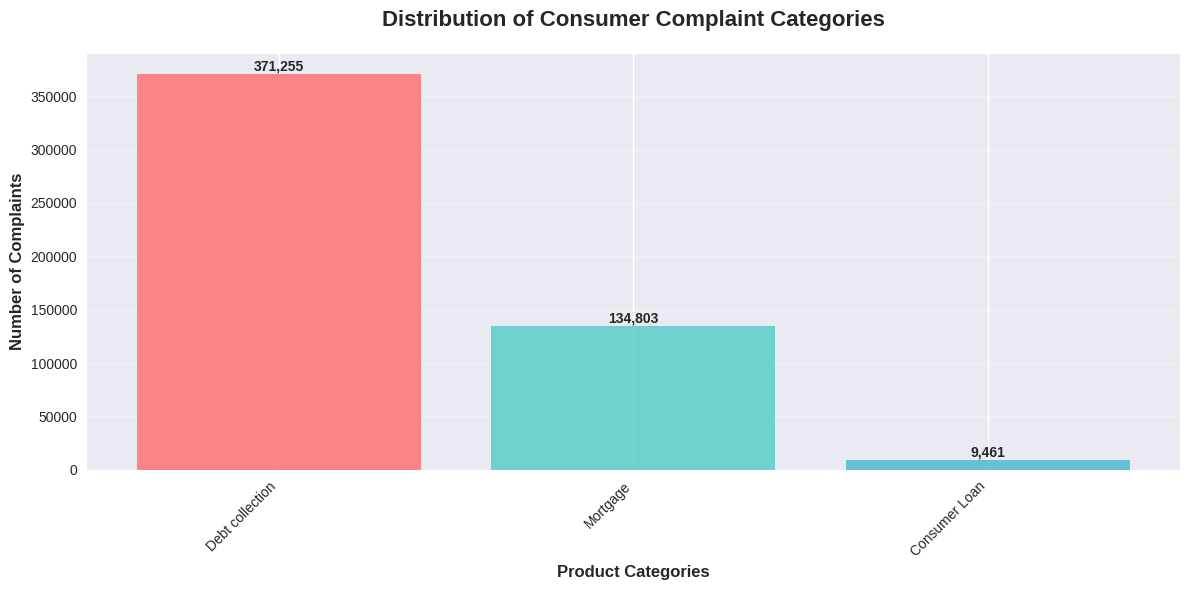


 Text Length Analysis:
   - Average complaint length: 1126.04 characters
   - Shortest complaint: 5 characters
   - Longest complaint: 32616 characters
   - Standard deviation: 1415.61 characters


<Figure size 1200x700 with 0 Axes>

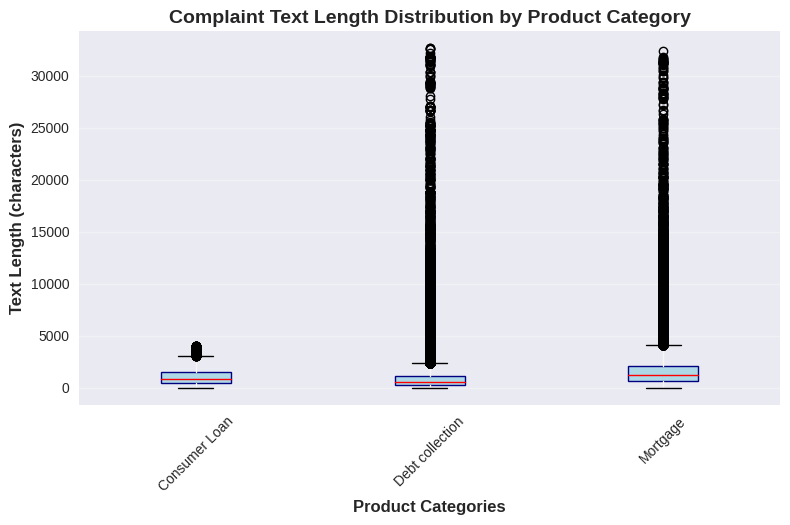


üìù Sample complaints from each category:

Debt collection:
   RE : Attentively review my formal writ composed declaration of not proven complaint misinformation that is all or in part : deficient of the adequate current status in the fullness of TRUTH, ACCURACY,...

Mortgage:
   Rushmore Loan management XXXX will not permit applying for loan modification online and direct you to call. However, they do not answer the phone and the phone directs you to go online. 

I have spent...

Consumer Loan:
   I paid off my car loan XXXX 2015. Istill do have not received a clear titleafter numerous contact with loan co. 
have been paying full coverage $ XXXXper month. can get liability for $ XXXXfor 6 month...
EDA Completed Successfully!


In [6]:
# Cell 6: STEP 1 - EXPLANATORY DATA ANALYSIS & FEATURE ENGINEERING
print(" Dataset Overview:")
print(f"   - Total samples: {df.shape[0]:,}")
print(f"   - Number of categories: {len(df['Product'].unique())}")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nüìà Target Variable Analysis:")
print("Product Categories Distribution:")
for category, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {category}: {count:,} samples ({percentage:.1f}%)")

# Visualization 1: Bar chart of product distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.index, category_counts.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)

# Add value labels on bars
for bar, count in zip(bars, category_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.title('Distribution of Consumer Complaint Categories', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Product Categories', fontsize=12, fontweight='bold')
plt.ylabel('Number of Complaints', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Text length analysis
print("\n Text Length Analysis:")
df['text_length'] = df['Consumer complaint narrative'].str.len()
print(f"   - Average complaint length: {df['text_length'].mean():.2f} characters")
print(f"   - Shortest complaint: {df['text_length'].min()} characters")
print(f"   - Longest complaint: {df['text_length'].max()} characters")
print(f"   - Standard deviation: {df['text_length'].std():.2f} characters")

# Text length distribution by category
plt.figure(figsize=(12, 7))
df.boxplot(column='text_length', by='Product', grid=False, 
           patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='navy'),
           medianprops=dict(color='red'))
plt.title('Complaint Text Length Distribution by Product Category', 
          fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Product Categories', fontsize=12, fontweight='bold')
plt.ylabel('Text Length (characters)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Sample complaints from each category
print(f"\nüìù Sample complaints from each category:")
for category in df['Product'].unique():
    sample_complaint = df[df['Product'] == category]['Consumer complaint narrative'].iloc[0]
    print(f"\n{category}:")
    print(f"   {sample_complaint[:200]}...")

print("EDA Completed Successfully!")

 Text Cleaning Process Demonstration:
Original text (first 200 chars):
'RE : Attentively review my formal writ composed declaration of not proven complaint misinformation that is all or in part : deficient of the adequate current status in the fullness of TRUTH, ACCURACY,...'

Cleaned text (fast version):
'attentively review formal writ composed declaration proven complaint misinformation part deficient adequate current status fullness truth accuracy completeness timeliness documented ownership certifia...'

üîÑ Applying text cleaning to entire dataset...
Dataset size: 515,519 rows
 Text preprocessing completed!

 Cleaned Text Statistics:
   Average cleaned text length: 715.6 characters
   Minimum cleaned text length: 0 characters
   Maximum cleaned text length: 23686 characters

üìù Sample Comparison:
   Original: RE : Attentively review my formal writ composed declaration of not proven complaint misinformation that is all or in part : deficient of the adequate ...
   Cleaned:  atte

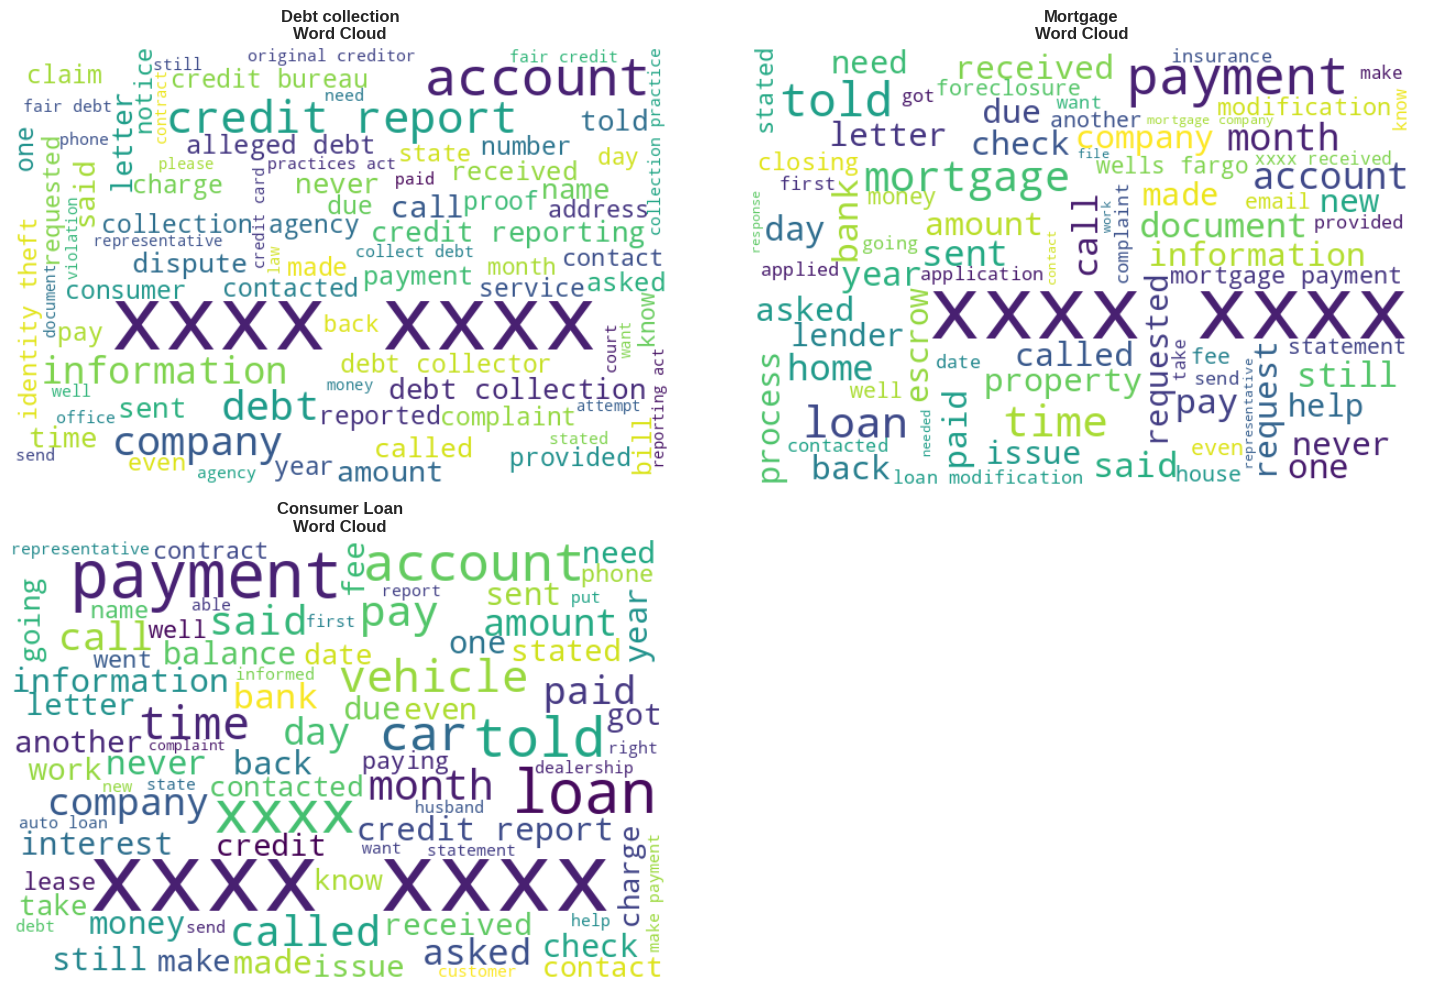

<Figure size 1200x600 with 0 Axes>

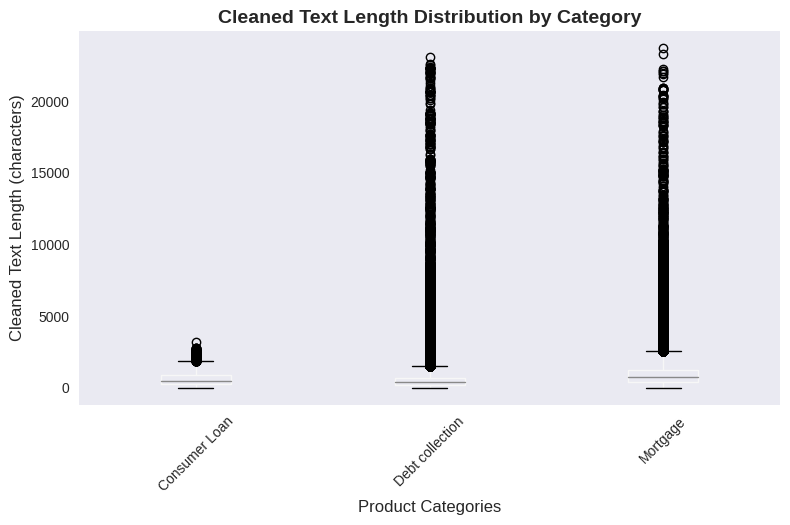

Text preprocessing and visualization completed!


In [7]:
# Cell 7: STEP 2 - TEXT PRE-PROCESSING

# Define optimized text cleaning function
def clean_text_fast(text):
    """
    Fast and optimized text cleaning function
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers in one pass
    text = re.sub(r'[^\w\s]|\d+', ' ', text)
    
    # Remove extra whitespace and strip
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Fast tokenization and stopword removal
    tokens = text.split()
    
    # Use set for faster stopword lookup and filter short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Return without lemmatization for speed, or use simple stemming
    return " ".join(tokens)

# Alternative: Simple stemmer (faster than lemmatization)
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def clean_text_with_stemming(text):
    """
    Text cleaning with fast stemming instead of lemmatization
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]|\d+', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and process
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Use fast stemming instead of lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

print(" Text Cleaning Process Demonstration:")
sample_text = df['Consumer complaint narrative'].iloc[0]
print(f"Original text (first 200 chars):")
print(f"'{sample_text[:200]}...'")

print(f"\nCleaned text (fast version):")
cleaned_sample = clean_text_fast(sample_text)
print(f"'{cleaned_sample[:200]}...'")

# Apply cleaning to entire dataset in batches for better performance
print(f"\nüîÑ Applying text cleaning to entire dataset...")
print(f"Dataset size: {len(df):,} rows")

# Process in smaller batches to avoid timeout
batch_size = 1000
total_batches = (len(df) + batch_size - 1) // batch_size

clean_texts = []
for i in range(0, len(df), batch_size):
    batch_end = min(i + batch_size, len(df))
    batch_texts = df['Consumer complaint narrative'].iloc[i:batch_end]
    
    # Use fast cleaning without lemmatization
    batch_clean = [clean_text_fast(text) for text in batch_texts]
    clean_texts.extend(batch_clean)

df['clean_text'] = clean_texts
print(" Text preprocessing completed!")

# Show statistics about cleaned text
print(f"\n Cleaned Text Statistics:")
df['clean_text_length'] = df['clean_text'].str.len()
print(f"   Average cleaned text length: {df['clean_text_length'].mean():.1f} characters")
print(f"   Minimum cleaned text length: {df['clean_text_length'].min()} characters")
print(f"   Maximum cleaned text length: {df['clean_text_length'].max()} characters")

# Show before and after comparison
print(f"\nüìù Sample Comparison:")
sample_idx = 0
print(f"   Original: {df['Consumer complaint narrative'].iloc[sample_idx][:150]}...")
print(f"   Cleaned:  {df['clean_text'].iloc[sample_idx][:150]}...")

# WordCloud visualization for a subset of data (faster)
print(f"\n Generating Word Clouds for each category...")

# Take sample from each category for faster word cloud generation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, category in enumerate(df['Product'].unique()):
    # Take sample of texts for faster processing
    category_texts = df[df['Product'] == category]['clean_text']
    sample_size = min(1000, len(category_texts))  # Limit for performance
    category_sample = category_texts.sample(n=sample_size, random_state=42)
    category_text = ' '.join(category_sample)
    
    # Generate word cloud
    try:
        wordcloud = WordCloud(
            width=600, 
            height=400, 
            background_color='white',
            max_words=80,  # Reduced for clarity
            colormap='viridis',
            random_state=42
        ).generate(category_text)
        
        # Plot
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'{category}\nWord Cloud', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    except Exception as e:
        print(f"   Could not generate word cloud for {category}: {e}")
        axes[idx].axis('off')
        axes[idx].text(0.5, 0.5, f'Word Cloud\nNot Available\nfor {category}', 
                      ha='center', va='center', transform=axes[idx].transAxes)

# Hide empty subplot if any
for idx in range(len(df['Product'].unique()), 4):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Distribution of text lengths after cleaning
plt.figure(figsize=(12, 6))
df.boxplot(column='clean_text_length', by='Product', grid=False)
plt.title('Cleaned Text Length Distribution by Category', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Product Categories', fontsize=12)
plt.ylabel('Cleaned Text Length (characters)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Text preprocessing and visualization completed!")

 Converting text to numerical features using TF-IDF...
TF-IDF Parameters:
  - max_features: 2000
  - ngram_range: (1, 2)
  - min_df: 5
  - max_df: 0.8
  - analyzer: word

 Fitting TF-IDF vectorizer...
 Feature extraction completed!

üìà Feature Matrix Details:
  - Shape: (515519, 2000)
  - Number of features: 2000
  - Sparsity: 97.33%
  - Data type: <class 'scipy.sparse._csr.csr_matrix'>

üìã Sample features (first 30):
   ability | able | absolutely | abuse | abusive | accept
   acceptance | accepted | access | accordance | according | according fcra
   accordingly | account | account account | account closed | account credit | account information
   account number | account opened | account paid | account removed | account reported | account xxxx
   accounting | accounts | accounts blocked | accounts credit | accounts report | accounts xxxx

 Top 20 most important features:
   xxxx: 0.1879
   xxxx xxxx: 0.1055
   debt: 0.0571
   credit: 0.0494
   account: 0.0422
   report: 0.0350
 

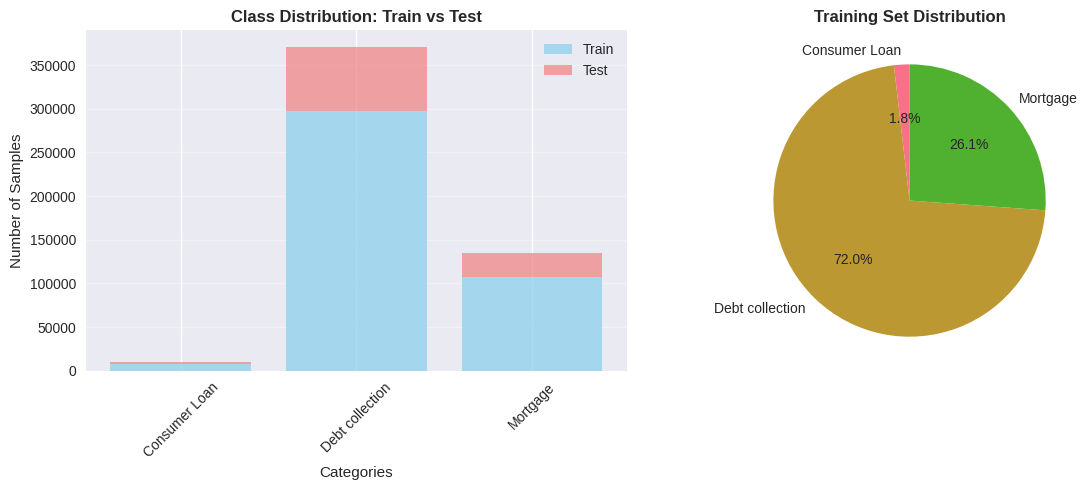

Feature extraction and data splitting completed!


In [8]:
# Cell 8: STEP 3 - FEATURE EXTRACTION
print(" Converting text to numerical features using TF-IDF...")

# Initialize TF-IDF Vectorizer with optimized parameters
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=5,            # Increased for better performance
    max_df=0.8,          # Slightly lower for better feature selection
    analyzer='word',
    lowercase=True
)

print("TF-IDF Parameters:")
print(f"  - max_features: 2000")
print(f"  - ngram_range: (1, 2)")
print(f"  - min_df: 5")
print(f"  - max_df: 0.8")
print(f"  - analyzer: word")

# Fit and transform the data
print("\n Fitting TF-IDF vectorizer...")
X = vectorizer.fit_transform(df['clean_text'])
print(" Feature extraction completed!")

print(f"\nüìà Feature Matrix Details:")
print(f"  - Shape: {X.shape}")
print(f"  - Number of features: {len(vectorizer.get_feature_names_out())}")
print(f"  - Sparsity: {(1 - (X.count_nonzero() / (X.shape[0] * X.shape[1]))) * 100:.2f}%")
print(f"  - Data type: {type(X)}")

# Show sample features
print(f"\nüìã Sample features (first 30):")
feature_samples = vectorizer.get_feature_names_out()[:30]
for i in range(0, len(feature_samples), 6):
    print("   " + " | ".join(feature_samples[i:i+6]))

# Most important features by mean TF-IDF score
print(f"\n Top 20 most important features:")
feature_means = np.array(X.mean(axis=0)).flatten()
top_feature_indices = np.argsort(feature_means)[::-1][:20]
top_features = [(vectorizer.get_feature_names_out()[i], feature_means[i]) 
                for i in top_feature_indices]

for feature, score in top_features:
    print(f"   {feature}: {score:.4f}")

# Prepare target variable - Use the existing label column
print(f"\n Using existing label encoding...")
# Make sure label column exists
if 'label' not in df.columns:
    print("   Creating label column...")
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['Product'])
else:
    print("   Label column already exists")

y = df['label'].values

print("Label Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    count = (df['Product'] == class_name).sum()
    print(f"   {class_name} ‚Üí {i} (samples: {count:,})")

# Train-test split
print(f"\n Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")
print(f"Feature dimension: {X_train.shape[1]:,}")
print(f"Training set sparsity: {(1 - (X_train.count_nonzero() / (X_train.shape[0] * X_train.shape[1]))) * 100:.2f}%")

# Display class distribution
print(f"\nüìà Class Distribution:")
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

dist_df = pd.DataFrame({
    'Category': label_encoder.classes_,
    'Train Samples': train_counts.values,
    'Test Samples': test_counts.values,
    'Train %': (train_counts.values / len(y_train) * 100).round(1),
    'Test %': (test_counts.values / len(y_test) * 100).round(1)
})
print(dist_df.to_string(index=False))

# Visualization: Class distribution in train/test
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(dist_df['Category'], dist_df['Train Samples'], color='skyblue', alpha=0.7, label='Train')
plt.bar(dist_df['Category'], dist_df['Test Samples'], color='lightcoral', alpha=0.7, label='Test', bottom=dist_df['Train Samples'])
plt.title('Class Distribution: Train vs Test', fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(dist_df['Train Samples'], labels=dist_df['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Training Set Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print("Feature extraction and data splitting completed!")

Training multiple classification models for comparison...
Model Parameters:
  - Logistic Regression: LogisticRegression(max_iter=500, random_state=42, solver='liblinear')
  - Naive Bayes: MultinomialNB(alpha=0.1)
  - Random Forest: RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50,
                       n_jobs=-1, random_state=42)
  - SVM: LinearSVC(dual=False, max_iter=500, random_state=42)

 Training Progress:

Training Logistic Regression...
 Logistic Regression
   - Accuracy: 0.9656
   - Training time: 25.02 seconds

Training Naive Bayes...
 Naive Bayes
   - Accuracy: 0.9463
   - Training time: 0.20 seconds

Training Random Forest...
 Random Forest
   - Accuracy: 0.9429
   - Training time: 35.47 seconds

Training SVM...
 SVM
   - Accuracy: 0.9656
   - Training time: 16.94 seconds

 MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Training_Time_Seconds
Logistic Regression  0.965617              25.017081
                SVM  0.965578             

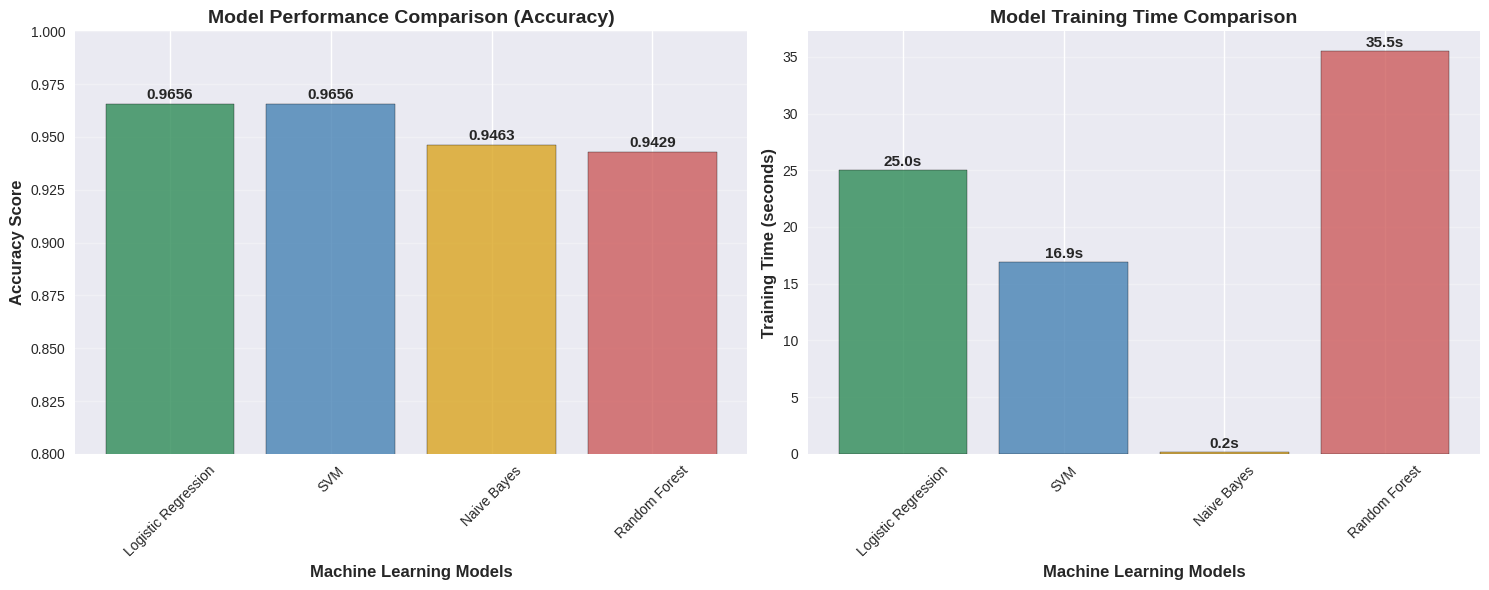


 BEST PERFORMING MODEL: Logistic Regression
   - Accuracy: 0.9656
   - Training Time: 25.02 seconds
   - Model Type: LogisticRegression
 Model training and comparison completed!


In [9]:
# Cell 9: STEP 4 - MODEL SELECTION & TRAINING

# Import time module for timing
import time

print("Training multiple classification models for comparison...")

# Define models with optimized parameters for faster training
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=500, 
        random_state=42,
        C=1.0,
        solver='liblinear'  # Faster for smaller datasets
    ),
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,  # Reduced for speed
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1  # Use all cores
    ),
    "SVM": LinearSVC(
        random_state=42, 
        max_iter=500,
        C=1.0,
        dual=False  # Faster for n_samples > n_features
    )
}

print("Model Parameters:")
for name, model in models.items():
    print(f"  - {name}: {model}")

# Train and evaluate models
results = {}
training_times = {}
print("\n Training Progress:")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Time the training
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f" {name}")
    print(f"   - Accuracy: {accuracy:.4f}")
    print(f"   - Training time: {training_time:.2f} seconds")

# Display results comparison
print("\n" + "="*50)
print(" MODEL PERFORMANCE COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values()),
    'Training_Time_Seconds': [training_times[name] for name in results.keys()]
})
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Visualization: Model Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
colors = ['#2E8B57', '#4682B4', '#DAA520', '#CD5C5C']
bars1 = ax1.bar(results_df['Model'], results_df['Accuracy'], 
               color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, accuracy in zip(bars1, results_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{accuracy:.4f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

ax1.set_title('Model Performance Comparison (Accuracy)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Machine Learning Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax1.set_ylim(0.8, 1.0)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Training time comparison
bars2 = ax2.bar(results_df['Model'], results_df['Training_Time_Seconds'], 
               color=colors, alpha=0.8, edgecolor='black')

for bar, time_val in zip(bars2, results_df['Training_Time_Seconds']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{time_val:.1f}s', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

ax2.set_title('Model Training Time Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Machine Learning Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_accuracy = results[best_model_name]

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   - Accuracy: {best_accuracy:.4f}")
print(f"   - Training Time: {training_times[best_model_name]:.2f} seconds")
print(f"   - Model Type: {type(best_model).__name__}")

print(" Model training and comparison completed!")

Evaluating Logistic Regression model in detail...

 DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

  Consumer Loan     0.7608    0.3631    0.4916      1892
Debt collection     0.9732    0.9841    0.9786     74251
       Mortgage     0.9513    0.9571    0.9542     26961

       accuracy                         0.9656    103104
      macro avg     0.8951    0.7681    0.8081    103104
   weighted avg     0.9636    0.9656    0.9633    103104


 OVERALL MODEL METRICS:
  - Weighted Precision: 0.9636
  - Weighted Recall:    0.9656
  - Weighted F1-Score:  0.9633
  - Accuracy:           0.9656

 PER-CLASS METRICS:
          Class  Precision   Recall  F1-Score  Support
  Consumer Loan   0.760797 0.363108  0.491592     1892
Debt collection   0.973241 0.984068  0.978624    74251
       Mortgage   0.951335 0.957086  0.954202    26961

 CONFUSION MATRIX:


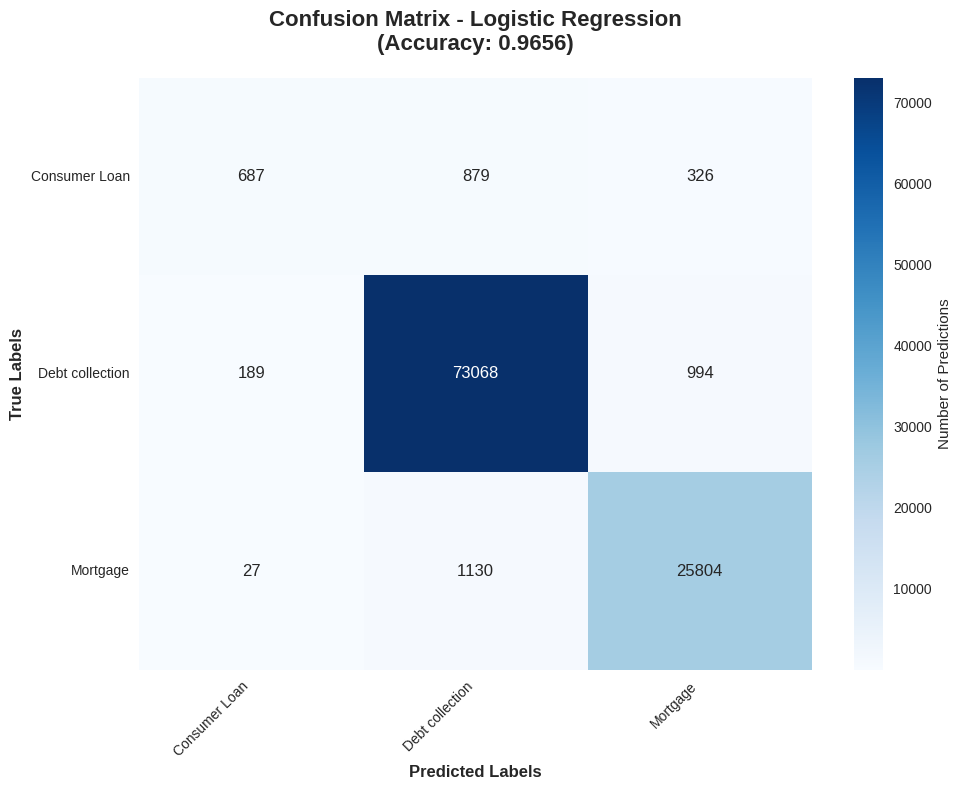


 NORMALIZED CONFUSION MATRIX (by row):


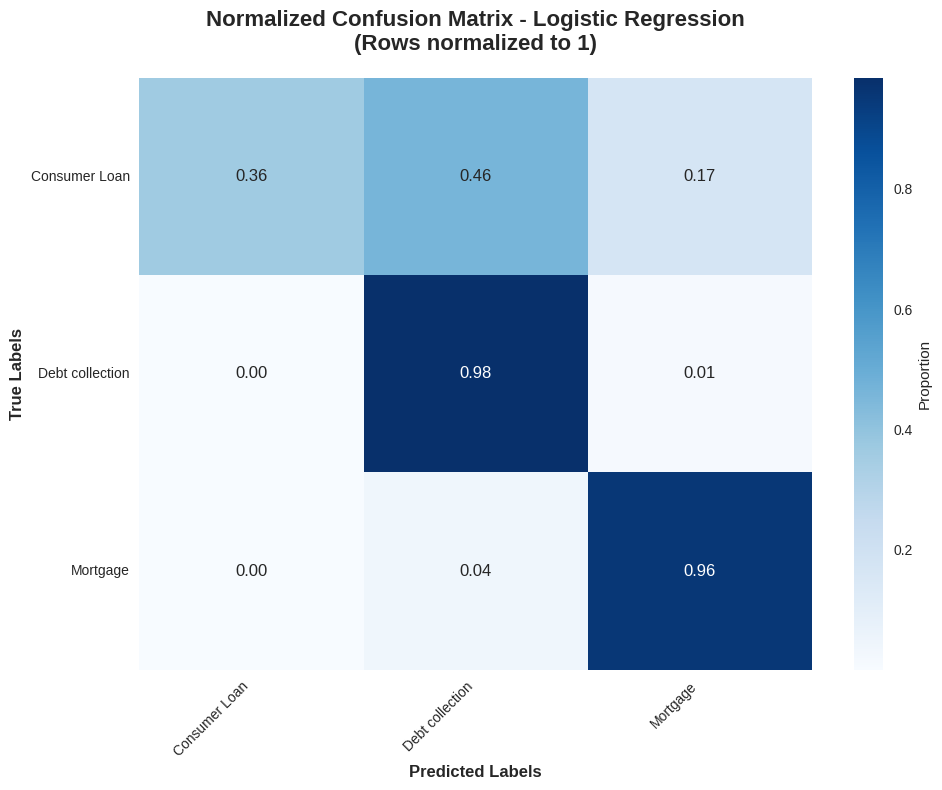


üîù TOP 20 MOST IMPORTANT FEATURES:
   mortgage: 18.4757
   debt: 7.9988
   escrow: 7.7166
   modification: 6.3954
   xxxxxxxx: 6.1956
   covid: 5.9445
   closing: 5.7220
   financial: 5.5395
   loan: 5.4562
   vehicle: 5.2603
   foreclosure: 5.2134
   car: 5.0905
   heloc: 4.9904
   didnt: 4.8545
   finance: 4.7181
   dont: 4.6620
   appraisal: 4.6304
   xxxxxxxx xxxx: 4.6278
   lease: 4.6117
   servicing: 4.6116
 Model evaluation completed!


In [10]:
# Cell 10: STEP 5 - MODEL EVALUATION

print(f"Evaluating {best_model_name} model in detail...")

# Get predictions from best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, 'predict_proba') else None

# Detailed classification report
print("\n DETAILED CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_,
                          digits=4))

# Calculate overall metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"\n OVERALL MODEL METRICS:")
print(f"  - Weighted Precision: {precision:.4f}")
print(f"  - Weighted Recall:    {recall:.4f}")
print(f"  - Weighted F1-Score:  {f1:.4f}")
print(f"  - Accuracy:           {accuracy:.4f}")

# Per-class metrics
print(f"\n PER-CLASS METRICS:")
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

class_metrics = []
for class_name in label_encoder.classes_:
    metrics = class_report[class_name]
    class_metrics.append({
        'Class': class_name,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1-score'],
        'Support': metrics['support']
    })

class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df.to_string(index=False))

# Confusion Matrix Visualization
print(f"\n CONFUSION MATRIX:")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Number of Predictions'},
            annot_kws={'size': 12})

plt.title(f'Confusion Matrix - {best_model_name}\n(Accuracy: {accuracy:.4f})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
print(f"\n NORMALIZED CONFUSION MATRIX (by row):")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion'},
            annot_kws={'size': 12})

plt.title(f'Normalized Confusion Matrix - {best_model_name}\n(Rows normalized to 1)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature importance (if available)
if hasattr(best_model, 'coef_'):
    print(f"\nüîù TOP 20 MOST IMPORTANT FEATURES:")
    if hasattr(best_model, 'coef_'):
        feature_importance = np.abs(best_model.coef_[0])
    else:
        feature_importance = best_model.feature_importances_
    
    top_indices = np.argsort(feature_importance)[::-1][:20]
    top_features = [(vectorizer.get_feature_names_out()[i], feature_importance[i]) 
                    for i in top_indices]
    
    for feature, importance in top_features:
        print(f"   {feature}: {importance:.4f}")

print(" Model evaluation completed!")

In [11]:
# Cell 11: STEP 6 - PREDICTION ON NEW DATA

# Test samples for different categories
test_samples = [
    "My credit report still shows wrong data even after I filed a complaint with the credit bureau multiple times. They are not correcting the errors.",
    "A debt collector called me multiple times a day and used abusive language threatening to sue me if I don't pay immediately.",
    "I applied for a personal loan but was denied without proper explanation and the bank won't tell me why my application was rejected.",
    "The mortgage company charged me unexpected fees at closing and now they're adding late payment charges unfairly without notice."
]

print(" Testing model on sample complaints:\n")

def predict_with_confidence(text, model, vectorizer, label_encoder):
    """Predict category with confidence score"""
    # Preprocess
    clean_sample = clean_text_fast(text)
    sample_vec = vectorizer.transform([clean_sample])
    
    # Predict
    pred_label = model.predict(sample_vec)[0]
    predicted_category = label_encoder.inverse_transform([pred_label])[0]
    
    # Get confidence scores
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(sample_vec)[0]
        confidence = probabilities[pred_label]
        all_probs = {label_encoder.classes_[i]: f"{prob:.4f}" 
                    for i, prob in enumerate(probabilities)}
    else:
        # For models without probability, use decision function
        decision_scores = model.decision_function(sample_vec)
        if len(decision_scores.shape) > 1:  # Multi-class
            confidence = np.max(decision_scores) - np.min(decision_scores)
        else:  # Binary or single sample
            confidence = abs(decision_scores[0])
        confidence = min(max(confidence / 10, 0), 1)  # Rough normalization
        all_probs = {"score": f"{confidence:.4f}"}
    
    return predicted_category, confidence, all_probs

for i, sample_text in enumerate(test_samples, 1):
    print(f"Sample {i}:")
    print(f"    Complaint: '{sample_text}'")
    
    predicted_category, confidence, all_probs = predict_with_confidence(
        sample_text, best_model, vectorizer, label_encoder
    )
    
    print(f"    Predicted Category: {predicted_category}")
    print(f"    Confidence: {confidence:.2%}")
    
    if hasattr(best_model, 'predict_proba'):
        print(f"    All Class Probabilities:")
        for class_name, prob in all_probs.items():
            print(f"      {class_name}: {prob}")
    
    print()

# Interactive prediction function
def predict_complaint_interactive():
    """Interactive function for predicting new complaints"""
    print("\n INTERACTIVE PREDICTION")
    print("Enter a consumer complaint (or 'quit' to exit):")
    
    while True:
        user_input = input("\nEnter complaint: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Exiting interactive mode...")
            break
        
        if not user_input:
            print("Please enter a complaint text.")
            continue
        
        predicted_category, confidence, all_probs = predict_with_confidence(
            user_input, best_model, vectorizer, label_encoder
        )
        
        print(f"\n PREDICTION RESULT:")
        print(f"   Category: {predicted_category}")
        print(f"   Confidence: {confidence:.2%}")
        
        if hasattr(best_model, 'predict_proba'):
            print(f"   Probability Distribution:")
            for class_name, prob in sorted(all_probs.items(), 
                                         key=lambda x: float(x[1]), reverse=True):
                print(f"      {class_name}: {float(prob):.2%}")

# Uncomment the line below to enable interactive prediction
# predict_complaint_interactive()

print("Prediction testing completed!")

 Testing model on sample complaints:

Sample 1:
    Complaint: 'My credit report still shows wrong data even after I filed a complaint with the credit bureau multiple times. They are not correcting the errors.'
    Predicted Category: Debt collection
    Confidence: 85.18%
    All Class Probabilities:
      Consumer Loan: 0.0160
      Debt collection: 0.8518
      Mortgage: 0.1322

Sample 2:
    Complaint: 'A debt collector called me multiple times a day and used abusive language threatening to sue me if I don't pay immediately.'
    Predicted Category: Debt collection
    Confidence: 99.94%
    All Class Probabilities:
      Consumer Loan: 0.0004
      Debt collection: 0.9994
      Mortgage: 0.0002

Sample 3:
    Complaint: 'I applied for a personal loan but was denied without proper explanation and the bank won't tell me why my application was rejected.'
    Predicted Category: Mortgage
    Confidence: 85.45%
    All Class Probabilities:
      Consumer Loan: 0.1311
      Debt collect

In [12]:
# Cell 12: STEP 7 - SAVING MODELS & COMPONENTS

import time
import joblib
import pickle
import dill

# Create a directory to save models
MODEL_DIR = "/kaggle/working/saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

print(" Saving models and components...")
print(f"Save directory: {MODEL_DIR}")

# Save the best model
best_model_path = os.path.join(MODEL_DIR, "best_model.pkl")
joblib.dump(best_model, best_model_path)
print(f" Best model saved: {best_model_path}")

# Save all trained models
all_models_path = os.path.join(MODEL_DIR, "all_models.pkl")
joblib.dump(models, all_models_path)
print(f" All models saved: {all_models_path}")

# Save the TF-IDF vectorizer
vectorizer_path = os.path.join(MODEL_DIR, "tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f" TF-IDF vectorizer saved: {vectorizer_path}")

# Save the label encoder
label_encoder_path = os.path.join(MODEL_DIR, "label_encoder.pkl")
joblib.dump(label_encoder, label_encoder_path)
print(f" Label encoder saved: {label_encoder_path}")

# Save the cleaned dataset (optional)
cleaned_data_path = os.path.join(MODEL_DIR, "cleaned_data.csv")
# Ensure label column exists
if 'label' not in df.columns:
    df['label'] = label_encoder.transform(df['Product'])
df[['Product', 'clean_text', 'label']].to_csv(cleaned_data_path, index=False)
print(f" Cleaned data saved: {cleaned_data_path}")

# Save model performance results
results_path = os.path.join(MODEL_DIR, "model_results.csv")
results_df.to_csv(results_path, index=False)
print(f" Model results saved: {results_path}")

# Save the clean_text function using dill
function_path = os.path.join(MODEL_DIR, "clean_text_function.pkl")
try:
    with open(function_path, 'wb') as f:
        dill.dump(clean_text_fast, f)
    print(f" Text cleaning function saved: {function_path}")
except Exception as e:
    print(f"  Dill failed, using pickle: {e}")
    with open(function_path, 'wb') as f:
        pickle.dump(clean_text_fast, f)
    print(f" Text cleaning function saved (pickle): {function_path}")

# Create a metadata file with important information
metadata = {
    'best_model': best_model_name,
    'best_accuracy': best_accuracy,
    'feature_count': X.shape[1],
    'classes': label_encoder.classes_.tolist(),
    'class_mapping': dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_)),
    'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset_shape': df.shape,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'model_type': type(best_model).__name__,
    'vectorizer_params': {
        'max_features': 2000,
        'ngram_range': (1, 2),
        'min_df': 5,
        'max_df': 0.8
    }
}

metadata_path = os.path.join(MODEL_DIR, "training_metadata.pkl")
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f" Training metadata saved: {metadata_path}")

# Save a requirements file
requirements_path = os.path.join(MODEL_DIR, "requirements.txt")
requirements = """
pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0.0
seaborn>=0.11.0
matplotlib>=3.5.0
nltk>=3.6.0
wordcloud>=1.8.0
joblib>=1.1.0
dill>=0.3.0
"""
with open(requirements_path, 'w') as f:
    f.write(requirements)
print(f" Requirements file saved: {requirements_path}")

print(f"\n SAVED FILES IN {MODEL_DIR}:")
print("="*40)
total_size = 0
for file in sorted(os.listdir(MODEL_DIR)):
    file_path = os.path.join(MODEL_DIR, file)
    size_kb = os.path.getsize(file_path) / 1024
    total_size += size_kb
    print(f"  {file:30} ({size_kb:7.1f} KB)")

print(f"   {'Total:':30} ({total_size:7.1f} KB)")

print(f"\n MODEL INFORMATION:")
print(f"   Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Features: {X.shape[1]:,}")
print(f"   Classes: {len(label_encoder.classes_)}")
print(f"   Dataset Size: {df.shape[0]:,} samples")

print("\n All models and components saved successfully!")

 Saving models and components...
Save directory: /kaggle/working/saved_models
 Best model saved: /kaggle/working/saved_models/best_model.pkl
 All models saved: /kaggle/working/saved_models/all_models.pkl
 TF-IDF vectorizer saved: /kaggle/working/saved_models/tfidf_vectorizer.pkl
 Label encoder saved: /kaggle/working/saved_models/label_encoder.pkl
 Cleaned data saved: /kaggle/working/saved_models/cleaned_data.csv
 Model results saved: /kaggle/working/saved_models/model_results.csv
 Text cleaning function saved: /kaggle/working/saved_models/clean_text_function.pkl
 Training metadata saved: /kaggle/working/saved_models/training_metadata.pkl
 Requirements file saved: /kaggle/working/saved_models/requirements.txt

 SAVED FILES IN /kaggle/working/saved_models:
  all_models.pkl                 ( 6199.3 KB)
  best_model.pkl                 (   47.8 KB)
  clean_text_function.pkl        (    1.1 KB)
  cleaned_data.csv               (368871.4 KB)
  label_encoder.pkl              (    0.5 KB)
  mo

In [13]:
# Cell 13: DEMONSTRATE LOADING SAVED MODELS

print("Testing model loading functionality...")

def load_saved_models(model_dir="/kaggle/working/saved_models"):
    """Load all saved models and components"""
    try:
        print(" Loading saved models and components...")
        
        # Load best model
        best_model = joblib.load(os.path.join(model_dir, "best_model.pkl"))
        print(f" Best model loaded: {type(best_model).__name__}")
        
        # Load vectorizer
        vectorizer = joblib.load(os.path.join(model_dir, "tfidf_vectorizer.pkl"))
        print(" TF-IDF vectorizer loaded")
        
        # Load label encoder
        label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))
        print(" Label encoder loaded")
        
        # Load cleaning function
        try:
            with open(os.path.join(model_dir, "clean_text_function.pkl"), 'rb') as f:
                clean_text_func = dill.load(f)
            print(" Text cleaning function loaded (dill)")
        except:
            with open(os.path.join(model_dir, "clean_text_function.pkl"), 'rb') as f:
                clean_text_func = pickle.load(f)
            print(" Text cleaning function loaded (pickle)")
        
        # Load metadata
        with open(os.path.join(model_dir, "training_metadata.pkl"), 'rb') as f:
            metadata = pickle.load(f)
        print(" Training metadata loaded")
        
        # Load results
        results_df = pd.read_csv(os.path.join(model_dir, "model_results.csv"))
        print(" Model results loaded")
        
        return best_model, vectorizer, label_encoder, clean_text_func, metadata, results_df
    
    except Exception as e:
        print(f" Error loading models: {e}")
        return None, None, None, None, None, None

# Test loading
loaded_best_model, loaded_vectorizer, loaded_label_encoder, loaded_clean_text, loaded_metadata, loaded_results = load_saved_models()

if loaded_best_model is not None:
    print(f"\n LOADED MODEL INFORMATION:")
    print(f"   Best Model: {loaded_metadata['best_model']}")
    print(f"   Accuracy: {loaded_metadata['best_accuracy']:.4f}")
    print(f"   Features: {loaded_metadata['feature_count']:,}")
    print(f"   Classes: {loaded_metadata['classes']}")
    print(f"   Model Type: {loaded_metadata['model_type']}")
    print(f"   Timestamp: {loaded_metadata['timestamp']}")
    
    # Test prediction with loaded models
    print(f"\n TESTING PREDICTION WITH LOADED MODELS:")
    test_samples = [
        "The debt collector harassed me with constant calls and threats to my family",
        "My mortgage application was rejected due to credit score errors from the reporting agency"
    ]
    
    for i, test_sample in enumerate(test_samples, 1):
        clean_test = loaded_clean_text(test_sample)
        test_vec = loaded_vectorizer.transform([clean_test])
        prediction = loaded_best_model.predict(test_vec)
        predicted_category = loaded_label_encoder.inverse_transform(prediction)[0]
        
        print(f"\nSample {i}:")
        print(f"   Text: '{test_sample}'")
        print(f"   Predicted: {predicted_category}")
        print(f"   Prediction successful with loaded models!")

print("\n Model saving and loading demonstration completed!")

Testing model loading functionality...
 Loading saved models and components...
 Best model loaded: LogisticRegression
 TF-IDF vectorizer loaded
 Label encoder loaded
 Text cleaning function loaded (dill)
 Training metadata loaded
 Model results loaded

 LOADED MODEL INFORMATION:
   Best Model: Logistic Regression
   Accuracy: 0.9656
   Features: 2,000
   Classes: ['Consumer Loan', 'Debt collection', 'Mortgage']
   Model Type: LogisticRegression
   Timestamp: 2025-10-19 15:37:06

 TESTING PREDICTION WITH LOADED MODELS:

Sample 1:
   Text: 'The debt collector harassed me with constant calls and threats to my family'
   Predicted: Debt collection
   Prediction successful with loaded models!

Sample 2:
   Text: 'My mortgage application was rejected due to credit score errors from the reporting agency'
   Predicted: Mortgage
   Prediction successful with loaded models!

 Model saving and loading demonstration completed!
